In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


In [2]:
#Data reading and splitting.
mnist_data = pd.read_csv('mnist.csv').values
labels = mnist_data[:, 0]
digits = mnist_data[:, 1:]

#random_state ensures that the split data is the same for each program iteration.
x_train, x_test, y_train, y_test = train_test_split(digits, labels, test_size=0.88, random_state=42)

<h3>Regularized multinomial logit model (using the LASSO penalty).</h3>

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

The logistic regression classifier by default applies L2 (Ridge) regularisation using the lbfgs solver. The liblinear and the saga solver, support both L1 (Lasso) and L2 regularisation. Liblinear is used for one vs rest schemes, which is appropriate for digit classification. We initially explored the differences between the two solvers, and found that saga seemed to perform better, to validate this we added it to as a hyperparameter.


In [ ]:
logitClf = LogisticRegression(random_state=0, penalty="l1", solver="saga").fit(x_train,y_train)
logitPred = logitClf.predict(x_test)


In [ ]:
logitClfLib = LogisticRegression(random_state=0, penalty="l1", solver="liblinear").fit(x_train,y_train)

In [ ]:
logitClf.score(x_train,y_train)

In [ ]:
logitClfLib.score(x_train,y_train)

In [ ]:
cm = confusion_matrix(y_test, logitPred, labels=[0,1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
disp.plot()
plt.title("Logistic Regression, saga solver with L1 regularisation, digit features")
plt.show()

<h3>K-Fold Cross Validation for Hyperparameter Tuning</h3>

We apply 5-fold cross validation to our models, and tune hyperparameters until the we hit diminishing returns (i.e not mutch change in mean cross validation error).
In a first round of hyperparameter tuning we used Cross Validation Grid search to apply 5-fold cross validation to all possible combinations of chosen parameters. The first round we tested five possible values for C [0.1,0.5,1,1.5,2] with the saga solver over 25 fits. The best fit was found at C=0.5 

In a second round, we added the solver as a hyperparameter with two options liblinear and saga and tested the following C values [0.3,0.4,0.5,0.6,0.7]. Where the best fit was present at 0.3 with the saga solver. (total of 50 fits) Yielding a crossvalidation accuracy of 88.6%

In a third round we tested the C-values [0.1,0.15,0.2,0.25,0.3,0.35] Here C=0.2 yielded the best result, which was rounded to 88.65, marginally better than for C=3. So we stopped tuning. And chose parameters C=0.2 and solver=saga.


In [3]:
skf = StratifiedKFold(n_splits=5, shuffle= True, random_state= 17)

In [ ]:

#Grid Search for parameter
#test 1 params = {'C': [0.1,0.5,1,1.5,2]} 
#test 2 params = {'C':  [0.3,0.4,0.5,0.6,0.7],'solver':["saga",'liblinear']}

params = {'C':  [0.1,0.15,0.2,0.25,0.3,0.35]}

best_logitComposition = GridSearchCV(estimator=logitClf, param_grid=params,
                              cv= skf, verbose= True, n_jobs=-1)

best_logitComposition.fit(x_train, y_train)

In [ ]:
best_logitComposition.best_params_

In [ ]:
best_logitComposition.best_score_

<h3>SVM Hyperparameter tuning</h3>
We use the same approach for hyperparameter tuning for the SVM, tuning using a 5-fold cross validation, tweaking the C value until we hit diminishing returns. 

Test 1: {'C':[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,1,1.5,2]} best C=2, cv accuracy: 0.886

Test 2: {'C':[1.5,1.7,1.9,2,2.2,2.4,2.5,2.8,3.0]} best {'C': 3} cv accuracy 0.955

Test 3: {'C':[3.0,3.5,4.0,4.5,5,5.5]} best {'C': 3.5} cv accuarcy 0.9561507936507937 (marginally better than Test 2 so we stop tuning)

In [4]:
svmClf = SVC(gamma='scale').fit(x_train,y_train)

In [6]:
svmClf.score(x_test,y_test)

0.9495941558441559

In [9]:
#params = {'C':[0.1,0.5,1,1.5,2]}
#Test1: params = {'C':[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,1,1.5,2]}
params = {'C':[3.0,3.5,4.0,4.5,5,5.5]}

best_svmComposition = GridSearchCV(estimator=svmClf, param_grid=params,
                              cv= skf, verbose= True, n_jobs=-1)

best_svmComposition.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': [3.0, 3.5, 4.0, 4.5, 5, 5.5]}, verbose=True)

In [10]:
best_svmComposition.best_params_

{'C': 3.5}

In [11]:
best_svmComposition.best_score_

0.9561507936507937

<h3>Model Comparison</h3>

In the previous step we have determined the best values for hyperparameter C, which for both the LogisticRegression Classifier and the SupportVector Classifier signifies the inverse regularisation strenght, using a grid parameter search over a 5 fold cross validation. Smaller values, specify stronger regularisation. For the LogisticRegression Classifier we additionally determined the best solver.  

We continue with the following parameters:
LogisticRegression: C=0.2, solver=saga 
SVC: C=3.5

<h4>Final Logistic Model</h4>

In [13]:
finalLogitClf = LogisticRegression(random_state=0, C=0.2, penalty="l1", solver="saga").fit(x_train,y_train)
finalLogitPred = finalLogitClf.predict(x_test)

d:\Programms\Python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [14]:
finalLogitClf.score(x_test,y_test)

0.8898538961038961

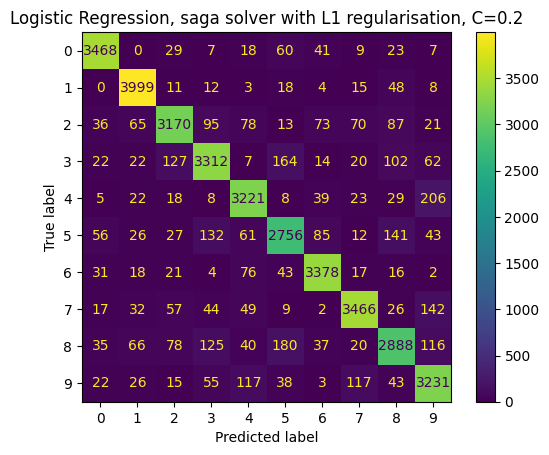

In [15]:
cm = confusion_matrix(y_test, finalLogitPred, labels=[0,1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
disp.plot()
plt.title("Logistic Regression, saga solver with L1 regularisation, C=0.2")
plt.show()

<h4>Final SVM Model</h4>

In [16]:
finalSvmClf = SVC(gamma='scale',C=3.5).fit(x_train,y_train)
finalSvmPred = finalSvmClf.predict(x_test)

In [17]:
finalSvmClf.score(x_test,y_test)

0.9566017316017316

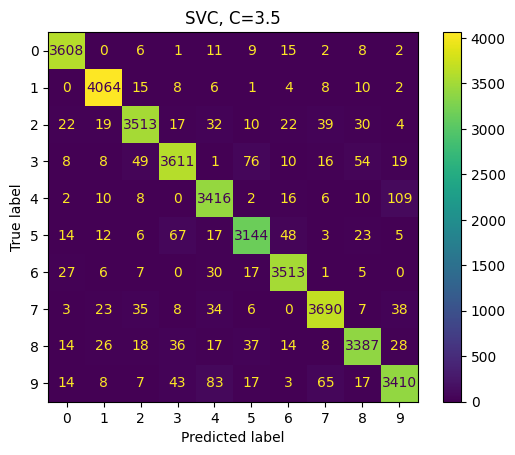

In [18]:
cm = confusion_matrix(y_test, finalSvmPred, labels=[0,1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
disp.plot()
plt.title("SVC, C=3.5")
plt.show()